# Sprint18課題 公開されている実装を動かす

## Faster R-CNN

Sprint16で読んだFaster R-CNN\[1\]の実装を動かします。

\[1\]Ren, S., He, K., Girshick, R., Sun, J.: Faster r-cnn: Towards real-time object detection with region proposal networks. In: Advances in neural information processing systems. (2015) 91–99

[https://arxiv.org/pdf/1506.01497.pdf](https://arxiv.org/pdf/1506.01497.pdf)

以下のものを使用してください。Kerasを使用した実装です。

[duckrabbits/ObjectDetection at master](https://github.com/duckrabbits/ObjectDetection/tree/master)

マウント

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 【問題1】学習と推定

READMEを参考に上記実装を動かしてください。

ディレクトリの移動

In [2]:
cd /content/drive/My Drive/ObjectDetection

/content/drive/My Drive/ObjectDetection


学習開始

In [11]:
%run train.py -p annotation.txt

Parsing annotation files
Training images per class (19 classes) :
{'abraham_grampa_simpson': 687,
 'apu_nahasapeemapetilon': 206,
 'bart_simpson': 650,
 'bg': 0,
 'charles_montgomery_burns': 650,
 'chief_wiggum': 209,
 'comic_book_guy': 208,
 'edna_krabappel': 212,
 'homer_simpson': 718,
 'kent_brockman': 213,
 'krusty_the_clown': 429,
 'lisa_simpson': 756,
 'marge_simpson': 629,
 'milhouse_van_houten': 210,
 'moe_szyslak': 403,
 'ned_flanders': 675,
 'nelson_muntz': 219,
 'principal_skinner': 614,
 'sideshow_bob': 201}
-------------------------------
path to config file : ./save/train_20190725-093454_config.pickle
-------------------------------
Epoch 1/1
100/100 [==============================] - 103s 1s/step - rpn_cls: 2.8040 - rpn_regr: 0.1547 - detector_cls: 4.3754 - detector_regr: 1.4128
Average number of overlapping bounding boxes from RPN = 18.53 for 100 previous iterations
Mean number of bounding boxes from RPN overlapping ground truth boxes: 18.623762376237625
Classifier accu

推定実施

In [13]:
!python predict.py -i simpsons_testset -c save/train_20190725-093454_config.pickle

Using TensorFlow backend.
W0725 09:58:13.836994 139661392590720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 09:58:13.849046 139661392590720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 09:58:13.855283 139661392590720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 09:58:13.892409 139661392590720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0725 09:58:15.572480 1396613

## 【問題2】論文と実装の対応

コードリーディングを行ってください。

まず、Faster R-CNN\[1\]において重要だと考えた部分を列挙してください。そして、それに対応するコードを見つけてください。

（例）

- RPNを実現しているコードはどこか
- RoIプーリングを実現しているコードはどこか

フレームワークには畳み込み層など一般的なものはクラスが用意されていますが、RoIプーリングなど特定の手法限定のものは用意されていません。オリジナルのレイヤーを作成することが可能であり、Kerasであれば以下のページに情報がまとまっています。

[オリジナルのKerasレイヤーを作成する - Keras Documentation](https://keras.io/ja/layers/writing-your-own-keras-layers/)

参考

KerasではVGG16のクラスが用意されているため、簡単に利用ができます。include_top=Falseの引数を与えることで、出力のための全結合層部分が除かれます。weights='imagenet'でImageNetを利用した学習済みモデルも手に入り、転移学習が行えます。weights='None'とすればランダムな初期化となります。

[Applications - Keras Documentation](https://keras.io/ja/applications/#vgg16)

### ・RPNを実現しているコードはどこか

In [0]:
# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)



import numpy as np
import pdb
import math
from . import data_generators
import copy


def calc_iou(R, img_data, C, class_mapping):

    bboxes = img_data['bboxes']
    (width, height) = (img_data['width'], img_data['height'])
    # get image dimensions for resizing
    resized_width, resized_height, _ = data_generators.get_new_img_size(width, height, C.im_size)

    gta = np.zeros((len(bboxes), 4))

    for bbox_num, bbox in enumerate(bboxes):
        # get the GT box coordinates, and resize to account for image resizing
        gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height))/C.rpn_stride))
        gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height))/C.rpn_stride))

    x_roi = []
    y_class_num = []
    y_class_regr_coords = []
    y_class_regr_label = []

    for ix in range(R.shape[0]):
        (x1, y1, x2, y2) = R[ix, :]
        x1 = int(round(x1))
        y1 = int(round(y1))
        x2 = int(round(x2))
        y2 = int(round(y2))

        best_iou = 0.0
        best_bbox = -1
        for bbox_num in range(len(bboxes)):
            curr_iou = data_generators.iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_bbox = bbox_num

        if best_iou < C.classifier_min_overlap:
                continue
        else:
            w = x2 - x1
            h = y2 - y1
            x_roi.append([x1, y1, w, h])

            if C.classifier_min_overlap <= best_iou < C.classifier_max_overlap:
                # hard negative example
                cls_name = 'bg'
            elif C.classifier_max_overlap <= best_iou:
                cls_name = bboxes[best_bbox]['class']
                cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
                cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0

                cx = x1 + w / 2.0
                cy = y1 + h / 2.0

                tx = (cxg - cx) / float(w)
                ty = (cyg - cy) / float(h)
                tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
                th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
            else:
                print('roi = {}'.format(best_iou))
                raise RuntimeError

        class_num = class_mapping[cls_name]
        class_label = len(class_mapping) * [0]
        class_label[class_num] = 1
        y_class_num.append(copy.deepcopy(class_label))
        coords = [0] * 4 * (len(class_mapping) - 1)
        labels = [0] * 4 * (len(class_mapping) - 1)
        if cls_name != 'bg':
            label_pos = 4 * class_num
            sx, sy, sw, sh = C.classifier_regr_std
            coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
            labels[label_pos:4+label_pos] = [1, 1, 1, 1]
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))
        else:
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))

    if len(x_roi) == 0:
        return None, None, None

    X = np.array(x_roi)
    Y1 = np.array(y_class_num)
    Y2 = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=1)

    return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0)

def apply_regr(x, y, w, h, tx, ty, tw, th):
    try:
        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy
        w1 = math.exp(tw) * w
        h1 = math.exp(th) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.
        x1 = int(round(x1))
        y1 = int(round(y1))
        w1 = int(round(w1))
        h1 = int(round(h1))

        return x1, y1, w1, h1

    except ValueError:
        return x, y, w, h
    except OverflowError:
        return x, y, w, h
    except Exception as e:
        print(e)
        return x, y, w, h

def apply_regr_np(X, T):
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X

def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    """
    Eliminating redundant object detection windows with a faster non maximum suppression method
    Greedily select high-scoring detections and skip detections that are significantly covered by 
    a previously selected detection.
    :param boxes: list of boxes 
    :param probs: list of probabilities relatives to the boxes
    """

    # code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes 
    pick = []

    # calculate the areas
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    
    # sort the bounding boxes 
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int + 0.5)
        hh_int = np.maximum(0, yy2_int - yy1_int + 0.5)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int / (area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

import time
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):

    regr_layer = regr_layer / C.std_scaling

    anchor_sizes = C.anchor_box_scales
    anchor_ratios = C.anchor_box_ratios

    assert rpn_layer.shape[0] == 1

    if dim_ordering == 'th':
        (rows,cols) = rpn_layer.shape[2:]

    elif dim_ordering == 'tf':
        (rows, cols) = rpn_layer.shape[1:3]

    curr_layer = 0
    if dim_ordering == 'tf':
        A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))
    elif dim_ordering == 'th':
        A = np.zeros((4, rpn_layer.shape[2], rpn_layer.shape[3], rpn_layer.shape[1]))

    for anchor_size in anchor_sizes:
        for anchor_ratio in anchor_ratios:

            anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
            anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
            if dim_ordering == 'th':
                regr = regr_layer[0, 4 * curr_layer:4 * curr_layer + 4, :, :]
            else:
                regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4]
                regr = np.transpose(regr, (2, 0, 1))

            X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

            A[0, :, :, curr_layer] = X - anchor_x/2
            A[1, :, :, curr_layer] = Y - anchor_y/2
            A[2, :, :, curr_layer] = anchor_x
            A[3, :, :, curr_layer] = anchor_y

            if use_regr:
                A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

            A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
            A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])
            A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
            A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

            A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
            A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
            A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
            A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

            curr_layer += 1

    all_boxes = np.reshape(A.transpose((0, 3, 1,2)), (4, -1)).transpose((1, 0))
    all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))

    x1 = all_boxes[:, 0]
    y1 = all_boxes[:, 1]
    x2 = all_boxes[:, 2]
    y2 = all_boxes[:, 3]

    idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

    all_boxes = np.delete(all_boxes, idxs, 0)
    all_probs = np.delete(all_probs, idxs, 0)

    result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

    return result

### ・RoIプーリングを実現しているコードはどこか

In [0]:
class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(1, rows, cols, channels)` if dim_ordering='tf'.
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.image_dim_ordering()
        assert self.dim_ordering in {'tf', 'th'}, 'dim_ordering must be in {tf, th}'

        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dim_ordering == 'th':
            self.nb_channels = input_shape[0][1]
        elif self.dim_ordering == 'tf':
            self.nb_channels = input_shape[0][3]

    def compute_output_shape(self, input_shape):
        if self.dim_ordering == 'th':
            return None, self.num_rois, self.nb_channels, self.pool_size, self.pool_size
        else:
            return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        img = x[0]
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]
            
            row_length = w / float(self.pool_size)
            col_length = h / float(self.pool_size)

            num_pool_regions = self.pool_size

            #NOTE: the RoiPooling implementation differs between theano and tensorflow due to the lack of a resize op
            # in theano. The theano implementation is much less efficient and leads to long compile times

            if self.dim_ordering == 'th':
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = x + ix * row_length
                        x2 = x1 + row_length
                        y1 = y + jy * col_length
                        y2 = y1 + col_length

                        x1 = K.cast(x1, 'int32')
                        x2 = K.cast(x2, 'int32')
                        y1 = K.cast(y1, 'int32')
                        y2 = K.cast(y2, 'int32')

                        x2 = x1 + K.maximum(1,x2-x1)
                        y2 = y1 + K.maximum(1,y2-y1)
                        
                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]

                        x_crop = img[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)

            elif self.dim_ordering == 'tf':
                x = K.cast(x, 'int32')
                y = K.cast(y, 'int32')
                w = K.cast(w, 'int32')
                h = K.cast(h, 'int32')

                rs = tf.image.resize_images(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
                outputs.append(rs)

        final_output = K.concatenate(outputs, axis=0)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        if self.dim_ordering == 'th':
            final_output = K.permute_dimensions(final_output, (0, 1, 4, 2, 3))
        else:
            final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output


## YOLOv3

シンプソンズのデータセットをFaster R-CNN以外の手法で学習・推定を行います。YOLOv3\[2\]のKeras実装を使います。

[qqwweee/keras-yolo3: A Keras implementation of YOLOv3 (Tensorflow backend)](https://github.com/qqwweee/keras-yolo3)

\[2\]Jeseph Redmon, Ali Farhadi. YOLOv3: An Incremental Improvement

[https://pjreddie.com/media/files/papers/YOLOv3.pdf](https://pjreddie.com/media/files/papers/YOLOv3.pdf)

Sprint18で使用した実装（再掲）

[lasershow/SimpsonRecognition: Detect and recognize The Simpsons characters using Keras and Faster R-CNN](https://github.com/lasershow/SimpsonRecognition)

## 【問題3】学習済みの重みによる推定

学習済みの重みを使い推定を行う方法がREADME.mdのQuick Startに記載されています。

まずはこの通りにして各自何かしらの画像や動画に対して検出を行ってください。

出力結果を課題の一部として提出してください。

In [46]:
%pwd

'/content/drive/My Drive/ObjectDetection/keras-yolo3'

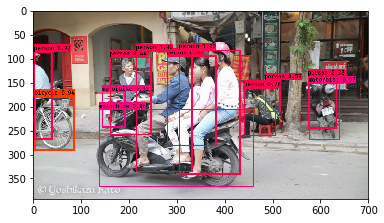

In [47]:
import matplotlib.pyplot as plt

img = plt.imread('aiueo.png')

fig, ax = plt.subplots()
ax.imshow(img)

plt.show()

## 【問題4】学習のためのファイルを作成

新しいデータ（シンプソンズデータセット）を学習します。README.mdのTrainingを読み、シンプソンズデータセットを学習するために必要なファイルを作成してください。

アノテーションファイルの形式がSprint18で扱った実装のものとは異なっているので、変換する必要があります。

In [0]:
#ファイルの読み込み
with open('annotation.txt') as f:
    txt = f.readlines()

In [0]:
class_dic = {}
class_num = 0


for i in txt:
    data = i.split(',')
    path = data[0] 
    annotation = data[1: -1]
    classes = data[-1] 
    
  
    if classes not in class_dic:
        class_dic[classes] = class_num
        class_num += 1
        
    #アノテーションファイルを作成
    with open('train.txt', 'a') as f_train:
        f_train.write(path + ' ' + ','.join(annotation)  + ',' + str(class_dic[classes]) + '\n')

In [0]:
#クラスファイル作成
for i in class_dic.keys():
    with open('class_label.txt', 'a') as f_class: 
        f_class.write(i)

## 【問題5】学習

問題4で作成したファイルを使用して学習してください。実行環境で学習に時間がかかる場合は、学習が行えることを確認するのみで終えて構いません。

In [37]:
!python convert.py yolov3.cfg yolov3.weights model_data/yolo_weights.h5

Using TensorFlow backend.
Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.
W0725 10:28:41.537910 140536730949504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 10:28:41.549187 140536730949504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)
W0725 10:28:41.551608 140536730949504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 10:28:41.564751 140536730949504 deprecation_wrapper.py:119] From /usr/l

In [44]:
%run train.py

Create YOLOv3 model with 9 anchors and 20 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 75) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 75) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Train on 7101 samples, val on 788 samples, with batch size 32.
Epoch 1/50
221/221 [==============================] - 672s 3s/step - loss: 577.9155 - val_loss: 66.3055
Epoch 2/50
 16/221 [=>............................] - ETA: 5:28 - loss: 68.5856

KeyboardInterrupt: ignored

学習できていることを確認し、interruput